In [2]:
import os
from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus.reader import PlaintextCorpusReader
import pandas as pd

In [3]:
data_dir = os.path.expanduser('../../../../data/corpora/UBirmingham/corpora/ChiLit')
os.path.isdir(data_dir)

True

In [5]:
chilit = PlaintextCorpusReader(root=data_dir, fileids='.*\.txt')

In [6]:
flist = chilit.fileids()

In [7]:
print(chilit.raw(fileids='princess.txt')[:500])

The Princess and the Goblin
George MacDonald

CHAPTER I. WHY THE PRINCESS HAS A STORY ABOUT HER


THERE was once a little princess who--

"_But, Mr. Author, why do you always write about princesses?_"

"_Because every little girl is a princess._"

"_You will make them vain if you tell them that._"

"_Not if they understand what I mean._"

"_Then what do you mean?_"

"_What_ do you _mean by a princess?_"

"_The daughter of a king._"

"_Very well, then every little girl is a princess, and there wo


In [8]:
words = chilit.words(fileids='princess.txt')
words[20:50]

['once',
 'a',
 'little',
 'princess',
 'who',
 '--',
 '"',
 '_But',
 ',',
 'Mr',
 '.',
 'Author',
 ',',
 'why',
 'do',
 'you',
 'always',
 'write',
 'about',
 'princesses',
 '?',
 '_',
 '"',
 '"',
 '_Because',
 'every',
 'little',
 'girl',
 'is',
 'a']

In [9]:
preproc_texts = [chilit.raw(fileids=d) for d in flist]

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
vectors = vectorizer.fit_transform(preproc_texts)

In [12]:
feature_names = vectorizer.get_feature_names()

/opt/homebrew/Caskroom/miniforge/base/envs/data/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names, index=flist)

In [15]:
df[df['006']> 0]['783']

unlikely.txt    0.00097
Name: 783, dtype: float64

In [16]:
df.shape

(71, 45596)

As we normalized per `l2` during the TF-IDF vectorization, we can just get the cosine distance with a simple dot product between each of the document vectors.

In [17]:
import numpy as np

dat = {}

for f in df.index:
    dat[f] = df.dot(df.loc[f])

result_df = pd.DataFrame.from_dict(data=dat)
result_df.head()

,alice.txt,alone.txt,amulet.txt,beauty.txt,brass.txt,bunny.txt,canada.txt,carved.txt,clive.txt,coral.txt,...,tombrown.txt,treasure.txt,unlikely.txt,vice.txt,wallypug.txt,water.txt,willows.txt,wind.txt,winning.txt,woodmagic.txt
alice.txt,1.000000,0.709823,0.814531,0.809757,0.755799,0.610989,0.781884,0.782063,0.785821,0.799495,...,0.810469,0.827673,0.855181,0.784663,0.820384,0.785912,0.787976,0.812115,0.785719,0.785999
alone.txt,0.709823,1.000000,0.731679,0.839114,0.749153,0.607817,0.756902,0.752237,0.732479,0.751023,...,0.812738,0.808179,0.827275,0.804314,0.779362,0.823957,0.789087,0.816050,0.745761,0.765660
amulet.txt,0.814531,0.731679,1.000000,0.852099,0.789632,0.642381,0.825717,0.777700,0.836802,0.852366,...,0.867655,0.885208,0.895656,0.822716,0.850200,0.833684,0.844210,0.841169,0.836124,0.833316
beauty.txt,0.809757,0.839114,0.852099,1.000000,0.840299,0.666229,0.875022,0.872078,0.833839,0.878769,...,0.912961,0.933027,0.921984,0.888425,0.884818,0.928833,0.890593,0.904125,0.847580,0.866987
brass.txt,0.755799,0.749153,0.789632,0.840299,1.000000,0.592466,0.800843,0.779188,0.777650,0.806326,...,0.823358,0.841377,0.827528,0.864627,0.818578,0.806022,0.801161,0.836511,0.794143,0.791102


In [18]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


def do_pca(df):
    pca = PCA(n_components=2)
    pca_corr_mat = pca.fit_transform(df)
    pca_res = pd.DataFrame(data = pca_corr_mat, columns = ['vector 1', 'vector 2'],
                           index = df.index)#, 'vector 3'])#, 'vector 4'])
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    return pca_res

def plot_pca(pca_res_df):
    plt.figure()
    plt.figure(figsize=(12,10))
    plt.axes(xlabel='Vector 1', ylabel='Vector 2')

    for i in pca_res_df.index:
        x, y = pca_res_df.loc[i]["vector 1"], pca_res_df.loc[i]["vector 2"]
        plt.scatter(x, y, s=50)
        plt.text(x+.005, y+.005, i, fontsize=10)
    plt.show()

In [19]:
res = do_pca(result_df)

[0.83257844 0.03822933]
0.870807772210189


<Figure size 432x288 with 0 Axes>

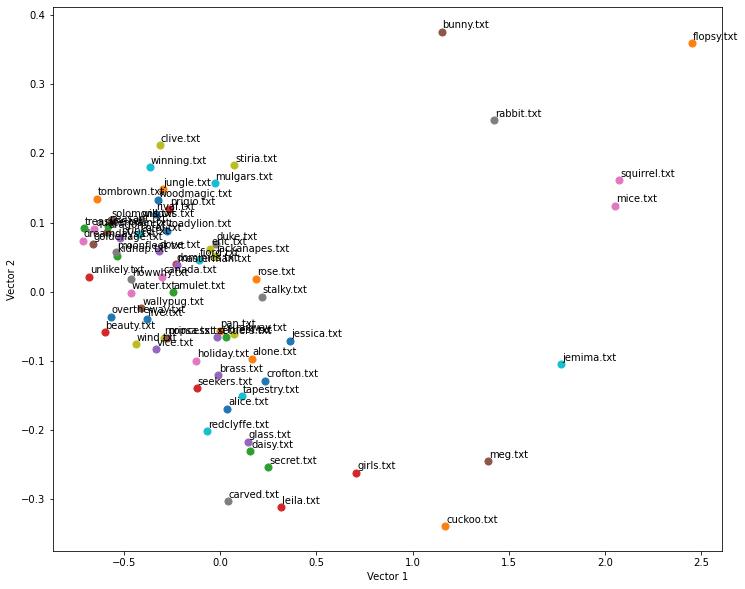

In [20]:
plot_pca(res)

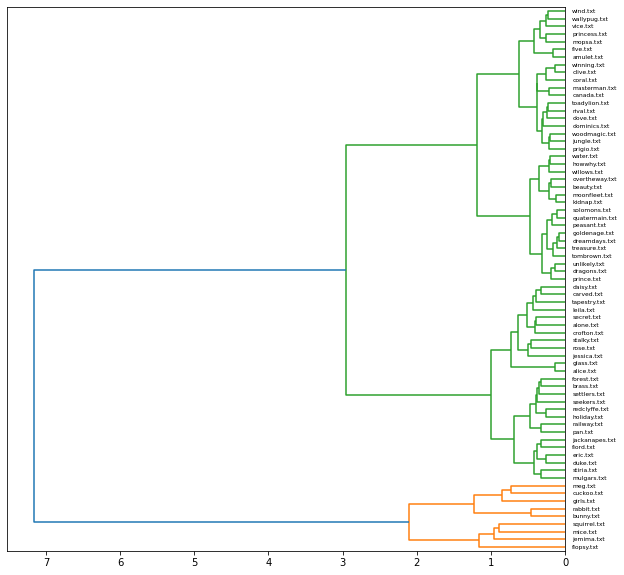

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams["figure.figsize"] = [10,10]

linkage_matrix = linkage(result_df, "ward")
dendrogram(linkage_matrix, labels=result_df.index, orientation='left')
# plt.savefig(os.path.expanduser('~/Desktop/dendro.pdf'))
plt.show()

Vedi [qui](https://stackoverflow.com/questions/14802048/scipy-dendrogram-leaf-label-colours) per assegnare un colore alle label

In [22]:
biblio_df = pd.read_csv('references.csv')
biblio_df.head()

,Item type,Authors,Editors,Title,Publication year,Publisher,Address,Date published,Date accessed,URLs,Keywords,Short title,Series
0,Book,Anstey F,NaN,The Brass Bottle,1900,NaN,NaN,1900,2017-09-10,https://www.gutenberg.org/ebooks/30689,ChiLit,brass,NaN
1,Book,Crockett SR,NaN,The Surprising Adventures of Sir Toady Lion wi...,1897,NaN,NaN,1897,2017-09-10,https://www.gutenberg.org/ebooks/39340,ChiLit,toadylion,NaN
2,Book,Mare W,NaN,The Three Mulla-mulgars,1910,NaN,NaN,1910,2017-09-10,https://www.gutenberg.org/ebooks/32620,ChiLit,mulgars,NaN
3,Book,Ewing JH,NaN,Mrs. Overtheway's Remembrances,1869,NaN,NaN,1869,2017-09-10,https://www.gutenberg.org/ebooks/17772,ChiLit,overtheway,NaN
4,Book,Ewing JH,NaN,Jackanapes,1883,NaN,NaN,1883,2017-09-10,https://www.gutenberg.org/ebooks/20351,ChiLit,jackanapes,NaN


In [23]:
auth_short = {}
for i,row in biblio_df.iterrows():
    if row.Keywords == "ChiLit":
        auth_short[f'{row["Short title"]}.txt'] = row.Authors


In [24]:
auth_short['princess.txt']

'MacDonald G'

In [25]:
set(auth_short.values())

{'Anstey F',
 'Austen J',
 'Ballantyne RM',
 'Barrie JM',
 'Braddon ME',
 'Brontë A',
 'Brontë C',
 'Brontë E',
 'Bulwer-Lytton E',
 'Burnett FH',
 'Carroll L',
 'Chesnutt CW',
 'Chopin K',
 'Collins W',
 'Conrad J',
 'Crockett SR',
 'Dickens C',
 'Disraeli B',
 'Doyle AC',
 'Dunbar PL',
 'Eliot G',
 'Ewing JH',
 'Falkner JM',
 'Farrar FW',
 'Farrow GE',
 'Forster EM',
 'Gaskell EC',
 'Gilman CP',
 'Grahame K',
 'Griggs SE',
 'Haggard HR',
 'Hardy T',
 'Harper FE',
 'Henty GA',
 'Hughes T',
 'Ingelow J',
 'James H',
 'Jefferies R',
 'Johnson JW',
 'Kingsley C',
 'Kipling R',
 'Lang A',
 'Lawrence DH',
 'MacDonald G',
 'Mahlberg M',
 'Mahlberg M,Wiegand V,Čermáková A',
 'Mare W',
 'Marryat F',
 'Martineau H',
 'Meade LT',
 'Molesworth NA',
 'Nesbit E',
 'Northup S',
 'Potter B',
 'Reed TB',
 'Rosato NJ,Rice C',
 'Ruskin J',
 'Sewell A',
 'Shelley MW',
 'Sinclair C',
 'Sinclair U',
 'Stevenson RL',
 'Stoker B',
 'Stretton H',
 'Strickland A',
 'Swift J',
 'Thackeray WM',
 'Trollope A',
 

In [28]:
df.loc['princess.txt'].sort_values(ascending=False).head(20)

the         0.599800
and         0.307427
curdie      0.271767
to          0.242187
of          0.218768
it          0.165238
irene       0.160164
she         0.155560
her         0.152311
you         0.140889
in          0.136242
was         0.135870
he          0.125833
that        0.116354
princess    0.099725
had         0.093864
but         0.091633
lootie      0.086045
as          0.083455
they        0.082340
Name: princess.txt, dtype: float64

In [30]:
df.loc['squirrel.txt'].sort_values(ascending=False).head(20)

nutkin          0.617768
the             0.388168
and             0.318082
squirrels       0.192407
of              0.150954
in              0.134780
brown           0.123947
twinkleberry    0.123554
old             0.120266
riddle          0.116956
hitty           0.098843
cuck            0.098843
his             0.097042
to              0.091651
mr              0.087699
but             0.086259
pitty           0.083895
up              0.080868
as              0.080868
nuts            0.077658
Name: squirrel.txt, dtype: float64